In [2]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
url = "https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package"
od.download(url)

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


In [4]:
os.listdir("weather-dataset-rattle-package")

['weatherAUS.csv']

In [5]:
raw_df = pd.read_csv("weather-dataset-rattle-package/weatherAUS.csv")

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [7]:
raw_df.dropna(subset=["RainTomorrow"], inplace=True)

In [8]:
year  = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year<2015]
val_df = raw_df[year==2015]
test_df = raw_df[year>2015]

In [9]:
input_cols = list(raw_df.columns)[1:-1]
target_col = "RainTomorrow"

In [10]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [11]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean").fit(raw_df[numeric_cols])

In [13]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [16]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [17]:
val_inputs.describe().loc[["min","max"]]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [20]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [21]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\Adithya Narayan\AppData\Local\Temp\ipykernel_6348\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Adithya Narayan\AppData\Local\Temp\ipykernel_6348\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Adithya Narayan\AppData\Local\Temp\ipykernel_6348\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  Thi

In [22]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
model = DecisionTreeClassifier(random_state=42)

In [25]:
model.fit(X_train,train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [27]:
train_preds = model.predict(X_train)

In [28]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'],
      shape=(98988,), dtype=object)

How did the model know what to predict(for here yes/no)?

It is because, what we asked to predict(for here X_train), contains yes/no values.

In [29]:
pd.value_counts(train_preds)

C:\Users\Adithya Narayan\AppData\Local\Temp\ipykernel_6348\1258350197.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


No     76707
Yes    22281
Name: count, dtype: int64

In [30]:
train_probs = model.predict_proba(X_train)

In [31]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(98988, 2))

In [32]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

In [33]:
model.score(X_val, val_targets)

0.7921188555510418

In [34]:
val_targets.value_counts() / len(val_targets)

RainTomorrow
No     0.788289
Yes    0.211711
Name: count, dtype: float64

In [35]:
from sklearn.tree import plot_tree, export_text

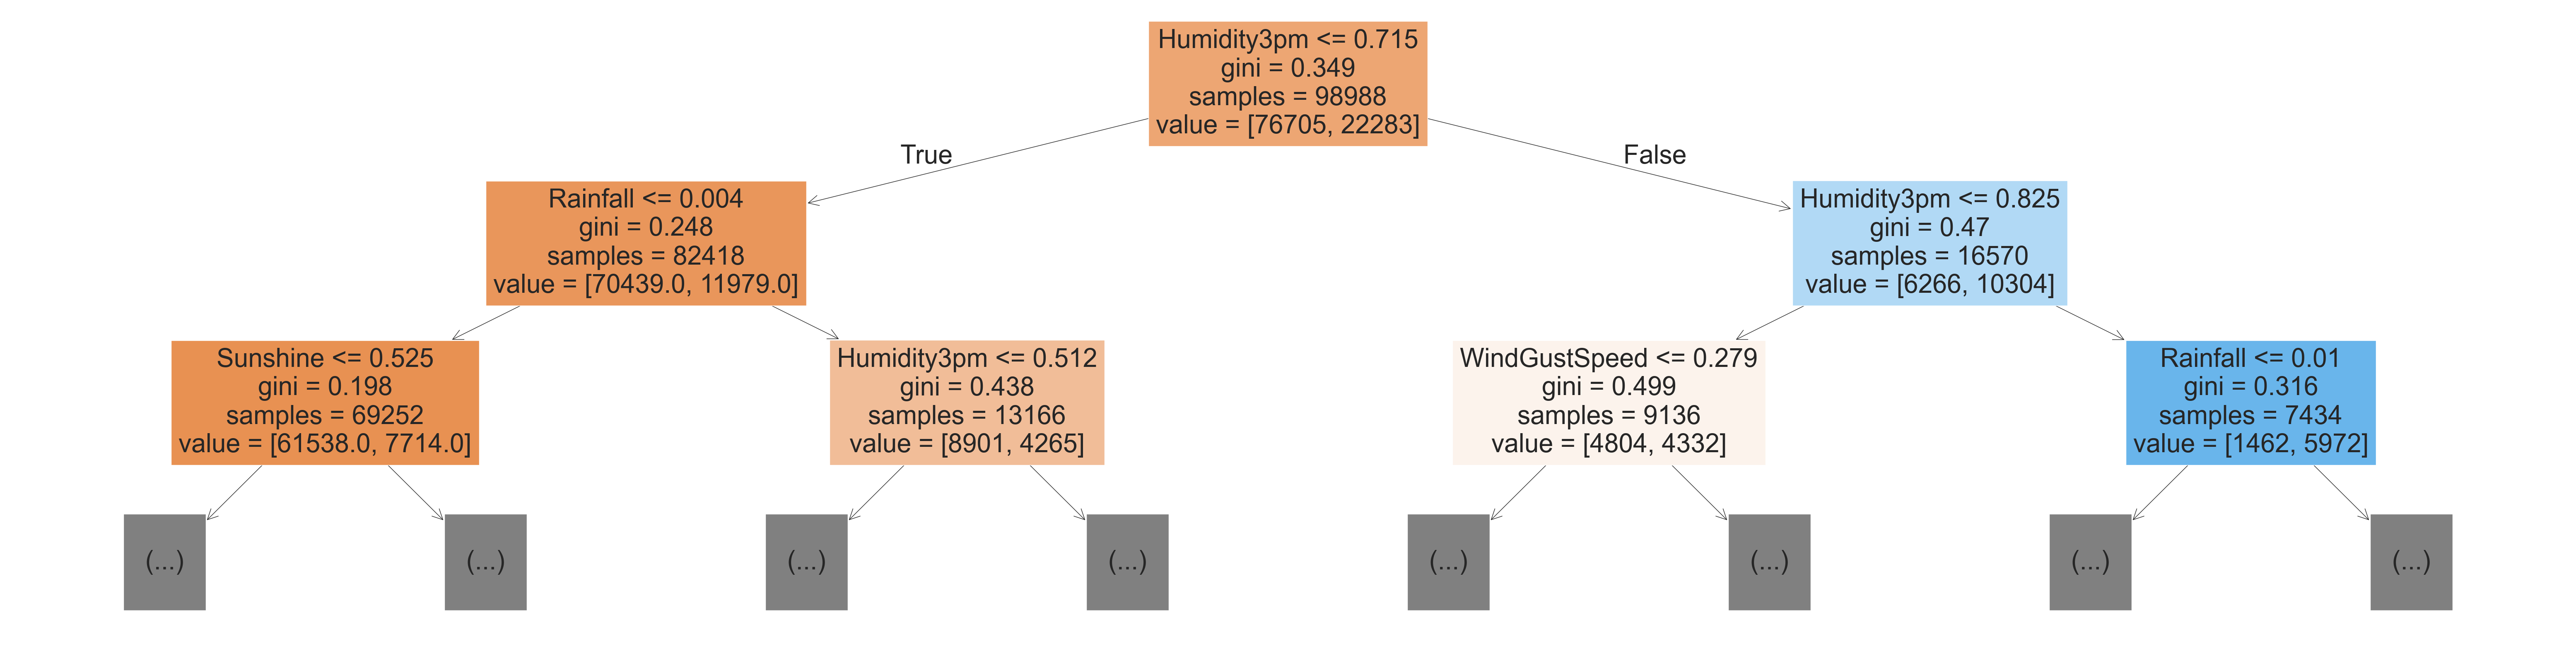

In [36]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [37]:
model.tree_.max_depth

48